# Designing models for CRC cell lines

In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import color_pal as pal
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_sampling_api
import seaborn as sns
import theano
from pymc3_models import crc_models

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 914
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [2]:
data = dphelp.read_achilles_data(
    Path("..", "modeling_data", "depmap_CRC_data_subsample.csv"), low_memory=False
)
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated
0,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
1,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
2,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
3,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
4,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0


## Model Experimentation

In [3]:
total_size = len(data.lfc.values)
sgrna_idx, n_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
sgrna_to_gene_map = (
    data[["sgrna", "hugo_symbol"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values("sgrna")
    .reset_index(drop=True)
)
sgrna_to_gene_idx, n_genes = dphelp.get_indices_and_count(
    sgrna_to_gene_map, "hugo_symbol"
)
cellline_idx, n_celllines = dphelp.get_indices_and_count(data, "depmap_id")

In [4]:
sgrna_idx_shared = theano.shared(sgrna_idx)
sgrna_to_gene_idx_shared = theano.shared(sgrna_to_gene_idx)
cellline_idx_shared = theano.shared(cellline_idx)
lfc_shared = theano.shared(data.lfc.values)

In [5]:
with pm.Model() as model:

    μ_g = pm.Normal("μ_g", -0.1, 3)
    σ_g = pm.HalfNormal("σ_g", 2)
    σ_σ_α = pm.HalfNormal("σ_σ_α", 2)

    μ_α = pm.Normal("μ_α", μ_g, σ_g, shape=n_genes)
    σ_α = pm.HalfNormal("σ_α", σ_σ_α, shape=n_genes)
    μ_β = pm.Normal("μ_β", 0, 0.5)
    σ_β = pm.HalfNormal("σ_β", 1)

    β_c = pm.Normal("β_c", μ_β, σ_β, shape=n_celllines)
    α_s = pm.Normal(
        "α_s",
        μ_α[sgrna_to_gene_idx_shared],
        σ_α[sgrna_to_gene_idx_shared],
        shape=n_sgrnas,
    )

    μ = pm.Deterministic("μ", α_s[sgrna_idx_shared] + β_c[cellline_idx_shared])
    σ = pm.HalfNormal("σ", 2)

    lfc = pm.Normal("lfc", μ, σ, observed=lfc_shared, total_size=total_size)

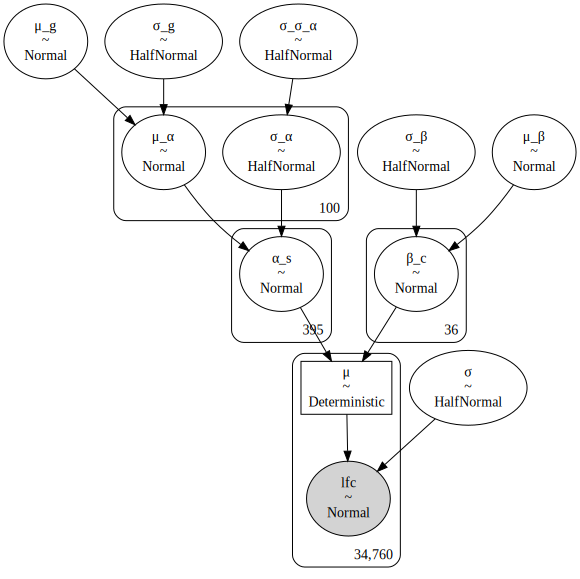

In [6]:
pm.model_to_graphviz(model)

In [7]:
batch_size = 1000

sgnra_idx_batch = pm.Minibatch(sgrna_idx, batch_size=batch_size)
cellline_idx_batch = pm.Minibatch(cellline_idx, batch_size=batch_size)
lfc_data_batch = pm.Minibatch(data.lfc.values, batch_size=batch_size)

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [8]:
meanfield = pymc3_sampling_api.pymc3_advi_approximation_procedure(
    model=model,
    method="advi",
    callbacks=[
        pm.callbacks.CheckParametersConvergence(tolerance=0.01, diff="absolute")
    ],
    fit_kwargs={
        "more_replacements": {
            sgrna_idx_shared: sgnra_idx_batch,
            cellline_idx_shared: cellline_idx_batch,
            lfc_shared: lfc_data_batch,
        }
    },
)

Sampling from prior distributions.
Running ADVI approximation.


Convergence achieved at 28100
Interrupted at 28,099 [28%]: Average Loss = 900.78


Sampling from posterior.
Posterior predicitons.


In [9]:
def plot_approximation_history(hist: np.ndarray) -> gg.ggplot:
    d = pd.DataFrame({"loss": hist}).reset_index(drop=False)
    return (
        gg.ggplot(d, gg.aes(x="index", y="loss"))
        + gg.geom_line(size=0.7, alpha=0.8, color=pal.sns_blue)
        + gg.scale_x_continuous(expand=(0.02, 0, 0.02, 0))
        + gg.labs(x="step", y="loss")
    )

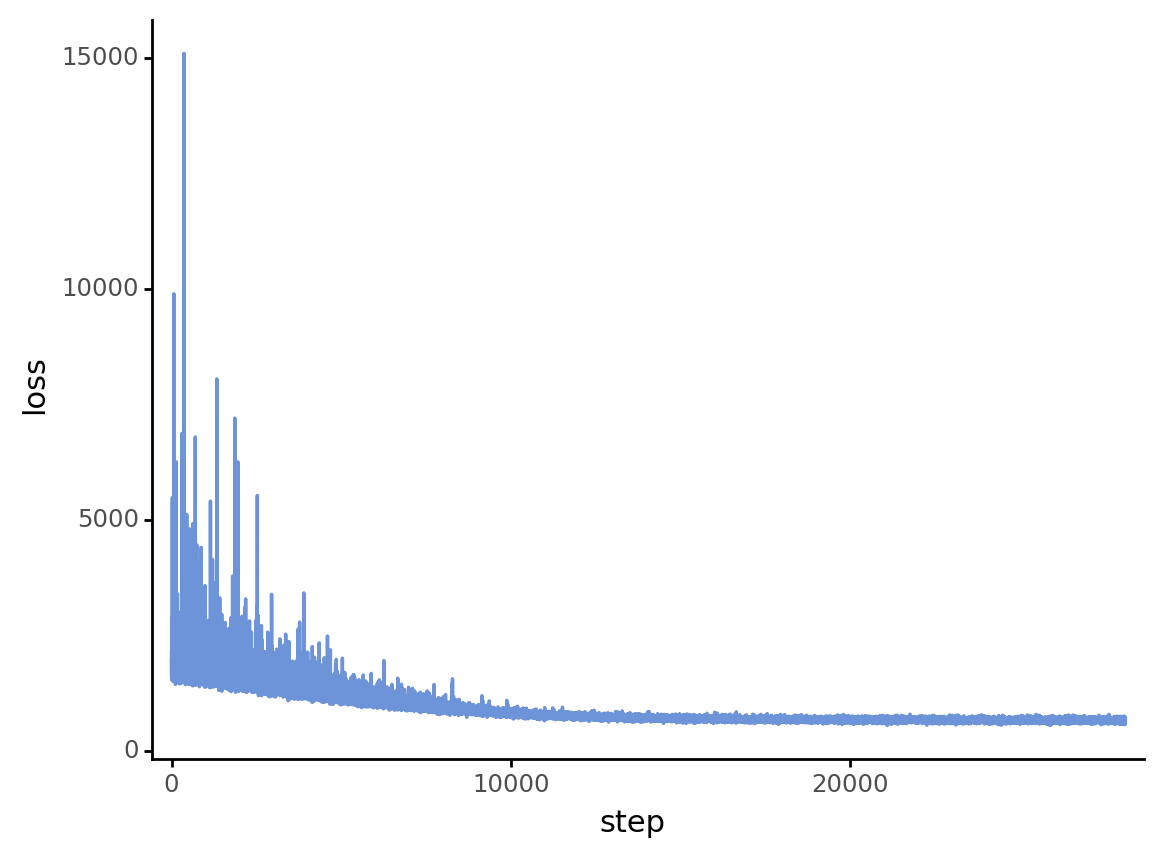

<ggplot: (8752244370008)>

In [10]:
plot_approximation_history(meanfield["approximation"].hist)

In [11]:
def plot_az_summary(df: pd.DataFrame, x="index") -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x=x))
        + gg.geom_hline(yintercept=0, linetype="--", alpha=0.5)
        + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.2)
        + gg.geom_point(gg.aes(y="mean"), size=0.5)
        + gg.theme(axis_text_x=gg.element_text(angle=90, size=6))
        + gg.labs(x="model parameter", y="posterior")
    )

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


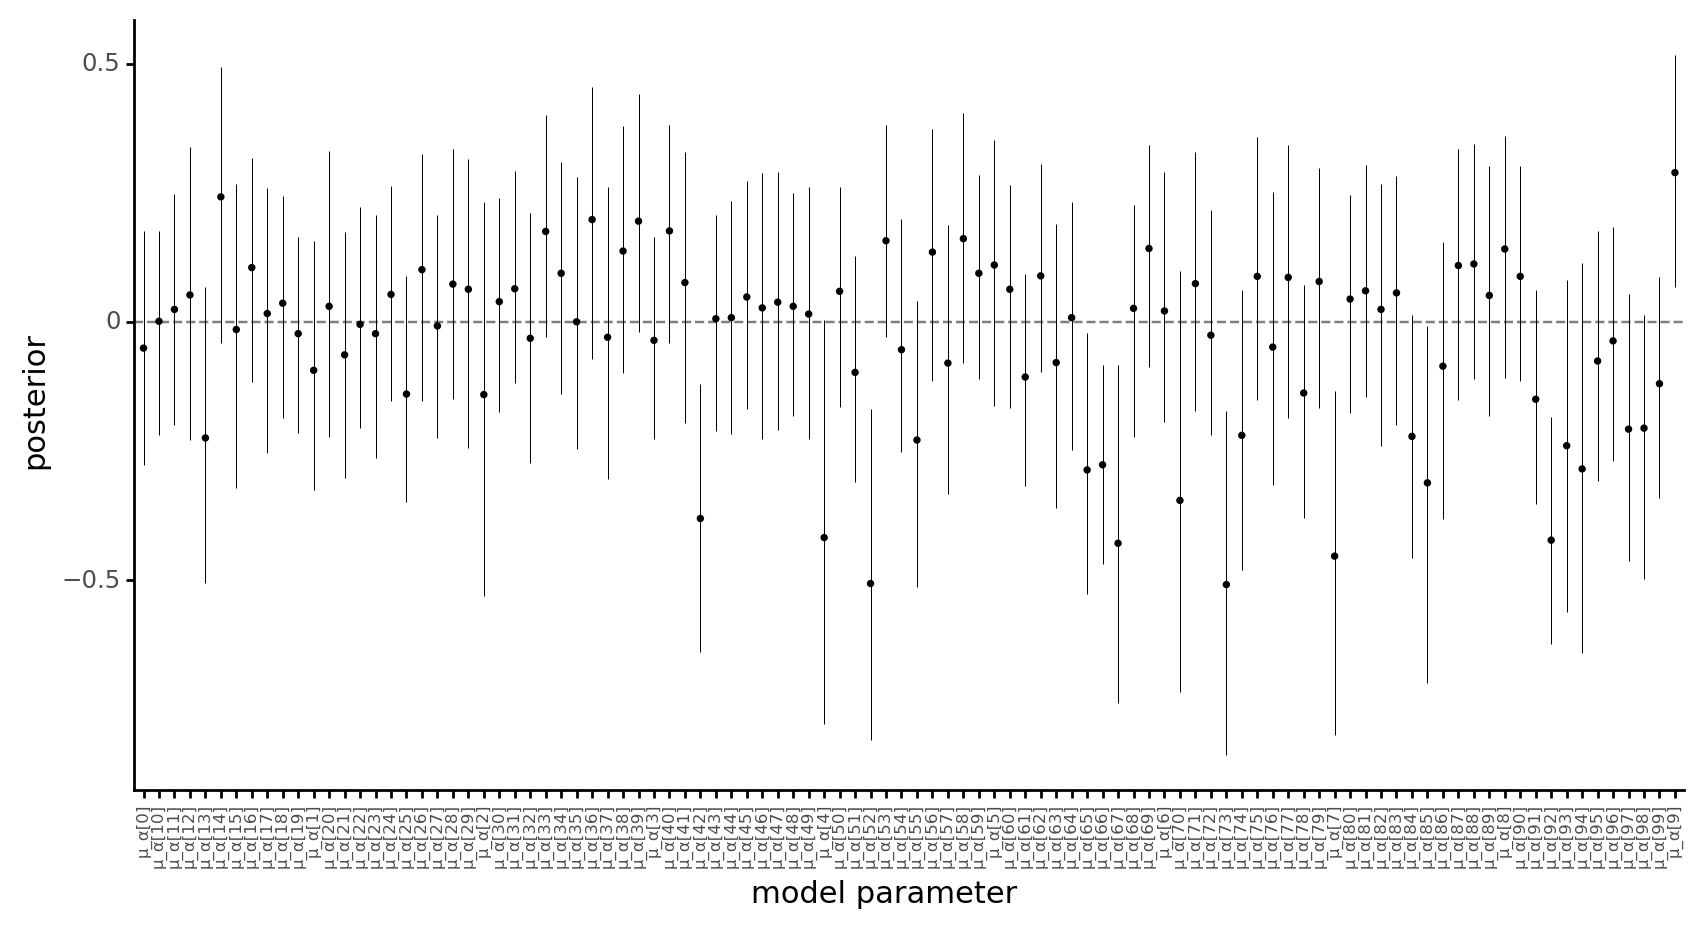

<ggplot: (8752270135004)>

In [12]:
gene_posteriors = az.summary(
    pymc3_sampling_api.samples_to_arviz(model, meanfield),
    var_names="μ_α",
    hdi_prob=0.89,
)

plot_az_summary(gene_posteriors.reset_index(drop=False)) + gg.theme(figure_size=(10, 5))

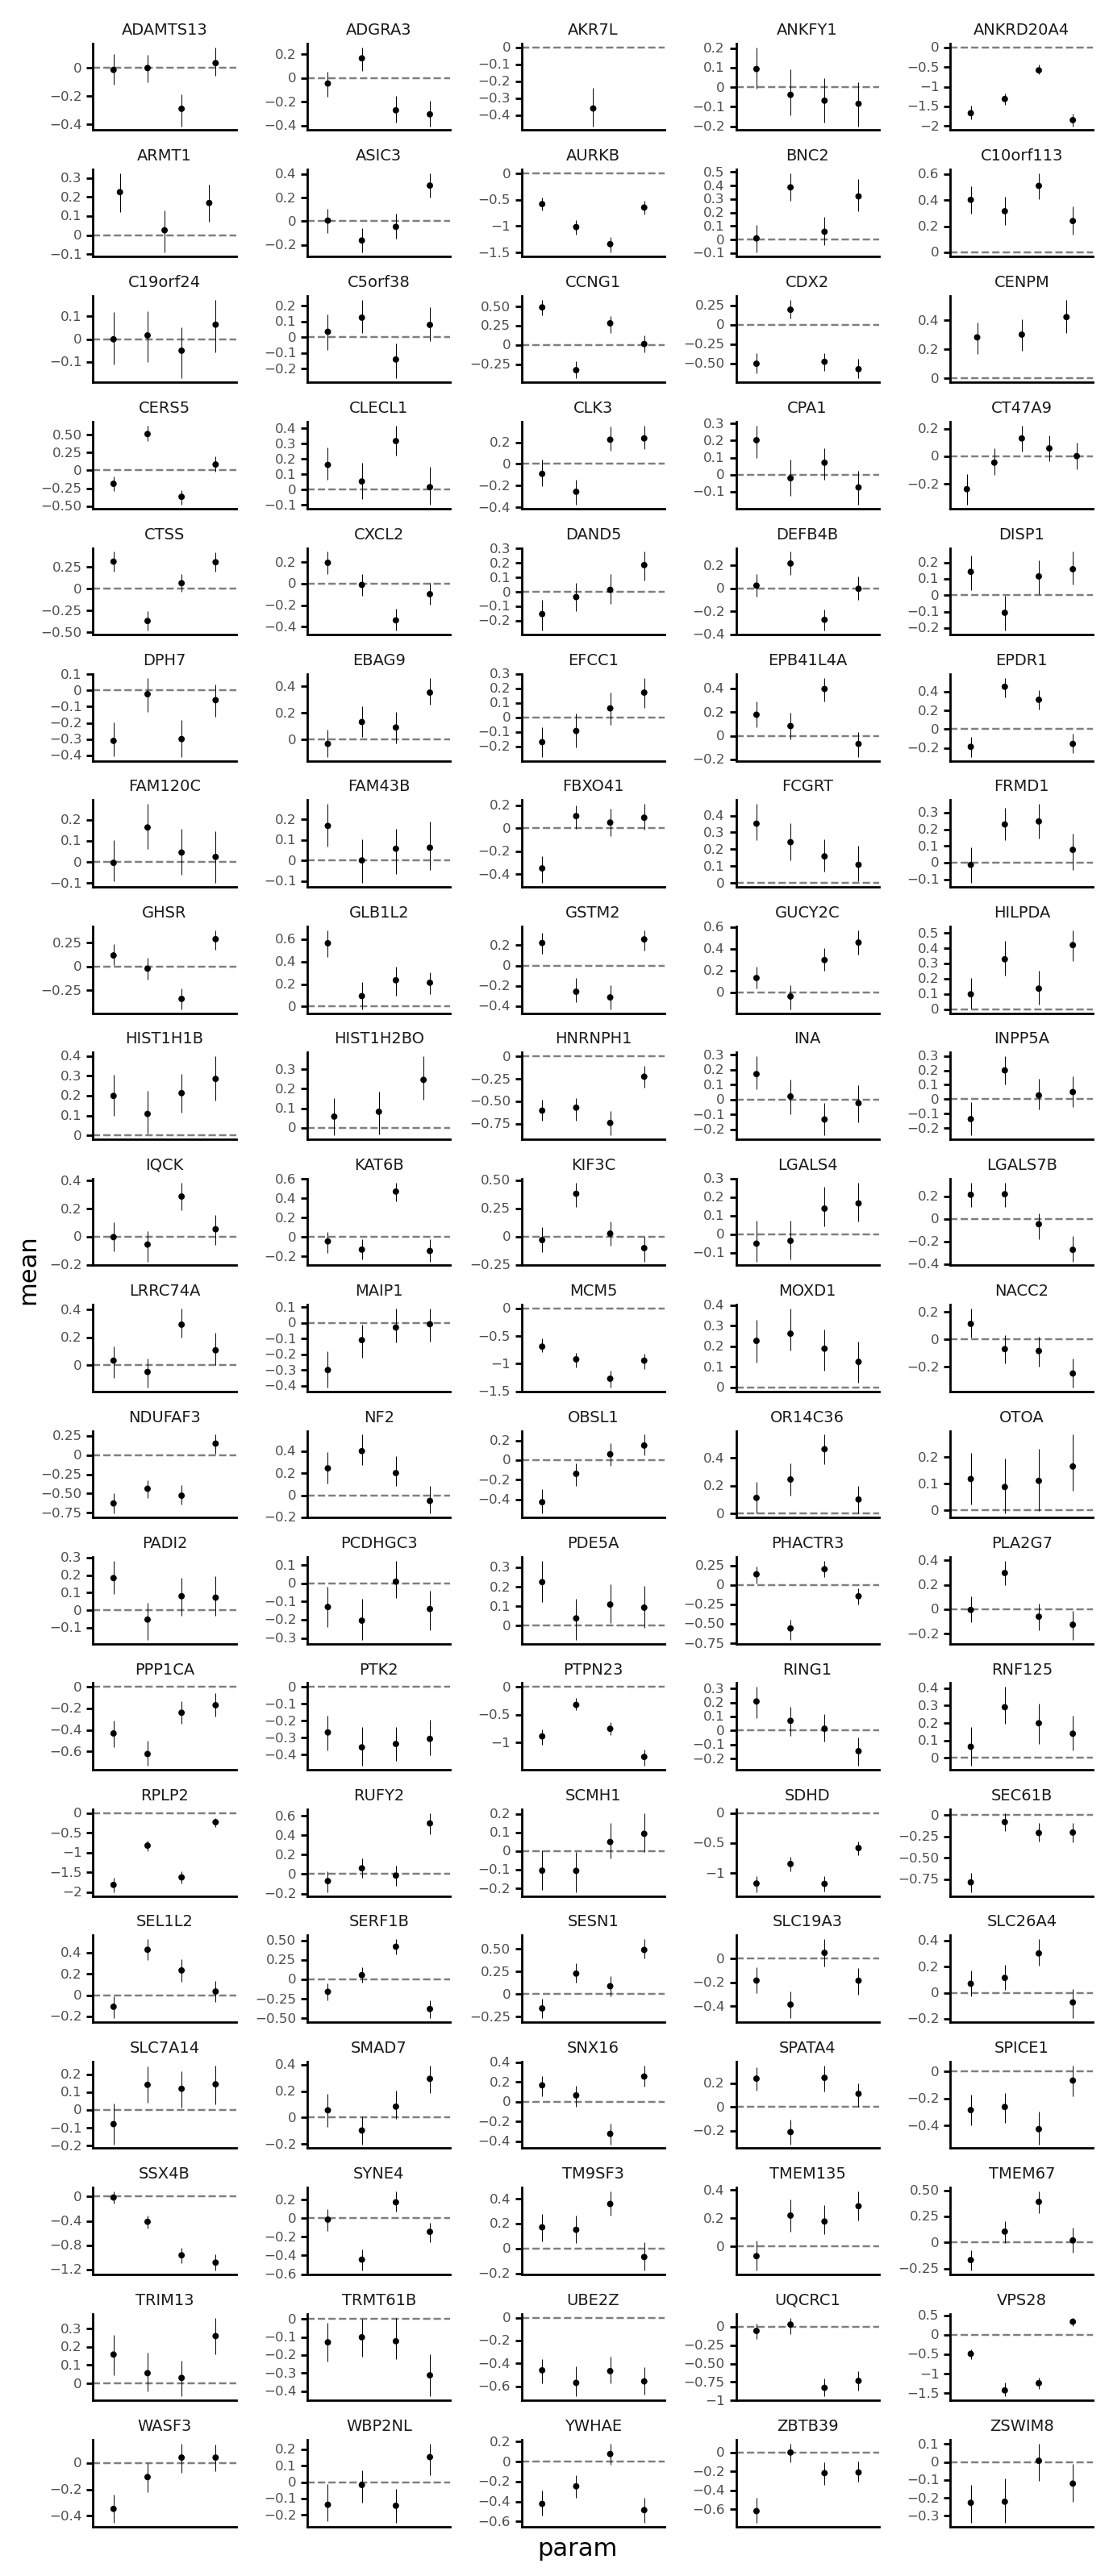

<ggplot: (8752244471896)>

In [13]:
sgrna_post = (
    az.summary(
        pymc3_sampling_api.samples_to_arviz(model, meanfield),
        var_names="α_s",
        hdi_prob=0.89,
        kind="stats",
    )
    .reset_index(drop=False)
    .rename(columns={"index": "param"})
)
sgrna_post["sgrna"] = sgrna_to_gene_map.sgrna
sgrna_post["hugo_symbol"] = sgrna_to_gene_map.hugo_symbol

(
    gg.ggplot(sgrna_post, gg.aes(x="param"))
    + gg.facet_wrap("hugo_symbol", scales="free", ncol=5)
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.2)
    + gg.geom_point(gg.aes(y="mean"), size=0.6)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(8, 20),
        subplots_adjust={"wspace": 0.5},
        axis_text_y=gg.element_text(size=6),
        axis_ticks_major_x=gg.element_blank(),
        strip_text=gg.element_text(size=7),
    )
)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


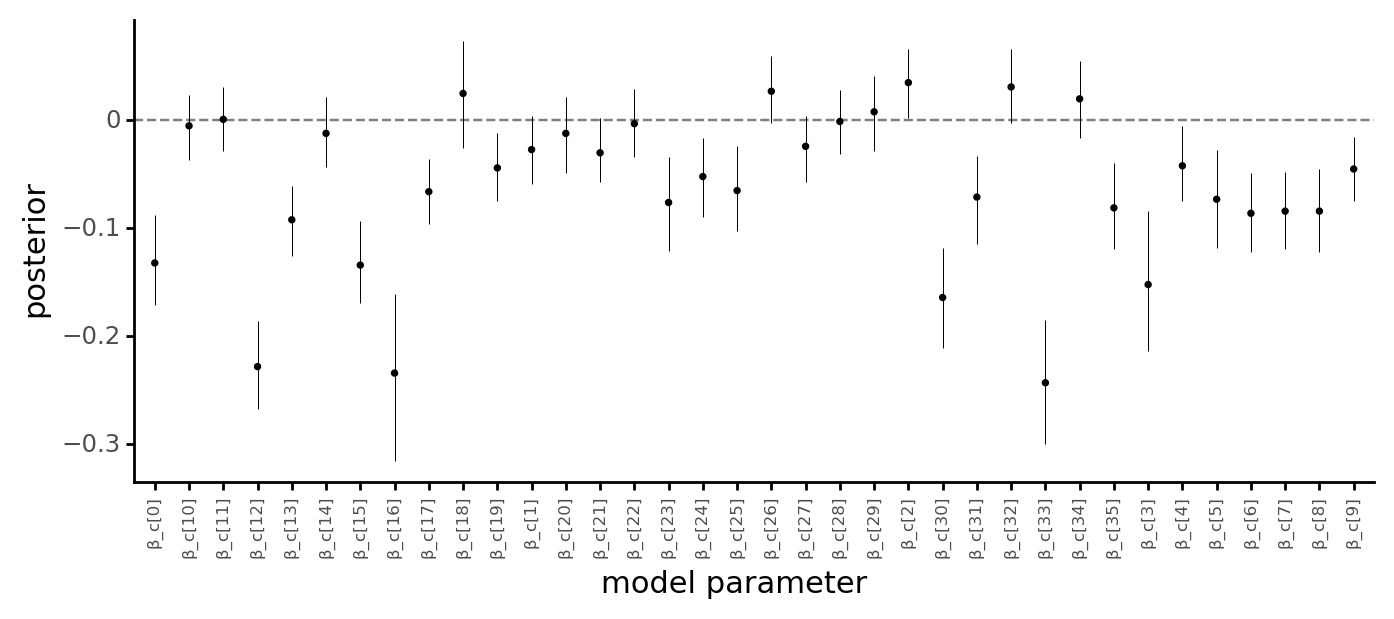

<ggplot: (8752226973925)>

In [14]:
cells_posteriors = az.summary(
    pymc3_sampling_api.samples_to_arviz(model, meanfield),
    var_names="β_c",
    hdi_prob=0.89,
)

plot_az_summary(cells_posteriors.reset_index(drop=False)) + gg.theme(figure_size=(8, 3))

---

In [15]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.52 minutes


In [16]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-19

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-86.o2.rc.hms.harvard.edu

Git branch: crc

theano    : 1.0.5
seaborn   : 0.11.1
arviz     : 0.11.1
matplotlib: 3.3.4
pandas    : 1.2.2
pymc3     : 3.11.1
re        : 2.2.1
numpy     : 1.20.1
plotnine  : 0.7.1

